In [1]:
from u import *
from env import E
from matplotlib import cm, patches

Root = Path('.')
Results = Root / 'results'

flow16 = [
    (700, 700), (850, 850),
    *[(850, 700 - 150 * i) for i in range(3)],
    *[(700 - 150 * i, 850) for i in range(3)],
    *[(1000, 850 - 150 * i) for i in range(4)],
    *[(850 - 150 * i, 1000) for i in range(4)],
]
flows = [f'flow{h}x{v}' for h, v in flow16]
flows_map = {flow: flow if h <= v else f'flow{v}x{h}' for (h, v), flow in zip(flow16, flows)}
vrange = hrange = [400, 550, 700, 850, 1000]
flows_hv = [f'flow{h}x{v}' for h in hrange for v in vrange]

symmetric_labels = [
    'Priority (Vertical)',
    'Signal Equal Phase',
    'Signal MaxPressure',
    'Oracle',
]
asymmetric_labels = [
    'Priority (Vertical)',
    'Priority (Horizontal)',
    'Signal Equal Phase',
    'Signal MaxPressure',
    'Oracle',
]

SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def plot_heatmap(eval_paths, baseline_paths, eval_labels, baseline_labels, plot_mask=None, vmin=85, show_text=True, w=5, barwidth=0.01, figsize=None):
    method_paths = eval_paths + baseline_paths[:-1]
    labels = eval_labels + baseline_labels[:-1]
    n_exp = len(method_paths)
    h = (n_exp - 1) // w + 1
    figsize = figsize or (14, 3 * h)
    fig, axes = plt.subplots(h, w, figsize=figsize)
    if axes.ndim == 1: axes = axes.reshape(1, -1)
    axes_flat = axes.reshape(-1)
    
    if plot_mask is None:
        plot_mask = np.arange(len(axes_flat)) < n_exp
    pm = plot_mask.reshape((h, w))
    x_visible = h - 1 - np.argmax(pm[::-1], axis=0)
    y_visible = np.argmax(pm, axis=1)
    
    optimal_dfs = {k: path.load() for k, path in baseline_paths[-1].items()}
    optimal_outflows = np.array([optimal_dfs[k].outflow_hourly.mean() if k in flows else np.nan for k in flows_hv])
    for i, (paths, label, ax) in enumerate(zip(method_paths, labels, axes_flat[plot_mask])):
        dfs = {k: path.load() for k, path in paths.items()}
        outflows = np.array([dfs[k].outflow_hourly.mean() if k in flows else np.nan for k in flows_hv])

        data = (outflows / optimal_outflows * 100).reshape(len(hrange), len(vrange))[::-1]
        outflows = outflows.reshape(len(hrange), len(vrange))[::-1]
        valid = ~np.isnan(data)
        im = ax.imshow(data, vmin=vmin, vmax=100, cmap=cm.Blues_r)
        for y, x in zip(*valid.nonzero()):
            t = str(round(data[y, x]))
            ax.text(x - 0.12 * len(t), y + 0.09, t, color='black' if data[y, x] > (100 * 0.25 + vmin * 0.75) else 'white')
        for y, x in zip(*(~valid).nonzero()):
            ax.add_patch(patches.Rectangle((x - 0.5, y - 0.5), 1, 1, facecolor='white', hatch='\\'))
        ax.set_title(label)
    
    for ax in axes_flat:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    
    for ax in axes_flat[~plot_mask]:
        ax.axis('off')
        
    for ax in axes[x_visible, np.arange(w)]:
        ax.xaxis.set_visible(True)
        ax.set_xticks(np.arange(data.shape[1]))
        ax.set_xticklabels(vrange[:data.shape[1]])
    for ax in axes[np.arange(h), y_visible]:
        ax.yaxis.set_visible(True)
        ax.set_yticks(np.arange(data.shape[0]))
        ax.set_yticklabels(hrange[::-1][:data.shape[0]])
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    pos0 = axes[0, 0].get_position()
    ax = axes_flat[plot_mask][-1]
    pos = ax.get_position()
    last_col_pos = axes[0, -1].get_position()
    total_height = pos0.y0 + pos0.height - pos.y0

    cbax = fig.add_axes([last_col_pos.x1 + barwidth, (1 - total_height) / 2, barwidth, total_height])
    cb_range = np.linspace(vmin, 100, 6).astype(int)
    cb = plt.colorbar(im, cax=cbax, label='% Oracle Outflow', ticks=cb_range)
    cb.ax.set_yticklabels([r'$\leq$ %d' % cb_range[0], *cb_range[1:-1], r'$\geq$ %d' % cb_range[-1]])
    
    oracle_ax = fig.add_axes([-0.1, (1 - pos.height) / 2, pos.width, pos.height])
    oracle_ax.set_title('Oracle Outflow (veh/hr)')
    oracle_ax.set_ylim([0, len(vrange)])
    oracle_ax.set_xlim([0, len(hrange)])
    oracle_ax.invert_yaxis()
    data = optimal_outflows.reshape(len(vrange), len(hrange))[::-1]
    for y, x in zip(*valid.nonzero()):
        oracle_ax.text(x + 0.5 - 0.45, y + 0.5 + 0.3, round(data[y, x]), color='black', rotation=30)
    for y, x in zip(*(~valid).nonzero()):
        oracle_ax.add_patch(patches.Rectangle((x, y), 1, 1, facecolor='black', hatch='\\'))

    oracle_ax.set_xticks(0.5 + np.arange(data.shape[1]))
    oracle_ax.set_xticklabels(vrange[:data.shape[1]])
    oracle_ax.set_xlabel(r'$f_V$ (veh/hr/lane)')
    oracle_ax.set_yticks(0.5 + np.arange(data.shape[0]))
    oracle_ax.set_yticklabels(hrange[::-1][:data.shape[0]])
    oracle_ax.set_ylabel(r'$f_H$ (veh/hr/lane)')
    
    plt.show()
    
def plot_time_space(vehicle_info, xml, colors=['C3', 'C2', 'C0', 'C4'], max_step=600, figsize=(15, 8)):
    edges = [Namespace(**edge) for edge in xml]
    lanes = [Namespace(**edge[0]) for edge in xml]
    
    jun_lanes = [l for l in lanes if l.id.startswith(':')]
    jun_lane_ids = [l.id for l in jun_lanes]
    in_edges, in_lanes = zip(*[(edge, lane) for edge, lane in zip(edges, lanes) if edge.get('to') == 'n_100.100'])
    in_edge_ids = [e.id for e in in_edges]
    in_lane_ids = [l.id for l in in_lanes]
    
    def parse_xy(s, number='(\d+)', sep='.'):
        return [(float(x), float(y)) for x, y in re.findall(f'{number}{sep}{number}', s)]
    
    def get_direction(xy1, xy2):
        (x1, y1), (x2, y2) = xy1, xy2
        direction = (int(np.sign(x2 - x1)), int(np.sign(y2 - y1)))
        return {(0, 1): 'Northbound', (0, -1): 'Southbound', (1, 0): 'Eastbound', (-1, 0): 'Westbound'}[direction]
    
    directions = {jl.id: get_direction(*parse_xy(jl.shape, number='([\d\.]+)', sep=',')) for jl in jun_lanes}       
    directions.update((l_i, get_direction(*parse_xy(l_i))) for l_i in in_lane_ids)
    hor = ['Westbound', 'Eastbound']
    
    intersection_info = vehicle_info.loc[vehicle_info.lane_id.isin(directions)]
    intersection_info['direction'] = intersection_info.lane_id.apply(directions.get)
    intersection_info['internal'] = intersection_info.lane_id.apply(lambda x: x.startswith(':'))
    
    start = intersection_info.step.min()
    intersection_info_trunc = intersection_info[intersection_info.step < start + max_step]
    end = intersection_info_trunc.step.max() + 1
    sim_step = 0.5
    L = 100
    labeled = {}
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    for direction, dir_group in intersection_info_trunc.groupby('direction'):
        ax = axes[0 if direction in hor else 1]
        for veh_id, veh_group in dir_group.groupby('id'):
            veh_type = veh_group.type.iloc[0]
            step = (veh_group.step - start).values
            
            space = veh_group.apply(lambda row: row.lane_position + (100 if row.internal else 0), axis=1).values
            
            if (space > 100).all():
                continue
            if (space > 100).any():
                i_end = np.argmax(space > 100)
                t_100 = step[i_end] - (space[i_end] - 100) / (space[i_end] - space[i_end - 1])
                assert 100 > space[i_end - 1]
                assert t_100 > step[i_end - 1]
                space = np.concatenate((space[:i_end], [100]))
                step = np.concatenate((step[:i_end], [t_100]))
            
            linestyle = '-'
            alpha = dict(human=0.5, rl=1)[veh_type]
            color = dict(zip(['Northbound', 'Eastbound', 'Southbound', 'Westbound'], colors))[direction]
            label = None
            if direction not in labeled and veh_type == 'rl':
                labeled[direction] = label = direction
            ax.plot(step * sim_step, space, color=color, linestyle=linestyle, alpha=alpha, label=label)
    topax, botax = axes
    for ax in axes:
        ax.set_ylim([0, L])
    topax.invert_yaxis()
    plt.xlim([0, (end - start) * sim_step])
    plt.xlabel('Time (s)')
    topax.set_ylabel('Horizontal\nLane Position (m)', wrap=True)
    botax.set_ylabel('Vertical\nLane Position (m)', wrap=True)
    plt.subplots_adjust(hspace=0)
    topax.legend(loc='lower right')
    botax.legend(loc='upper right')
    plt.show()

# Two-way 2x1

In [2]:
Baselines = Results / 'twoway_2x1_baselines'
Trained = {av: (Results / f'twoway_2x1_penetration{av}', ckpt)
    for av, ckpt in zip([0.1, 0.15, 0.333, 0.5, 1], [155, 180, 165, 150, 160])
}

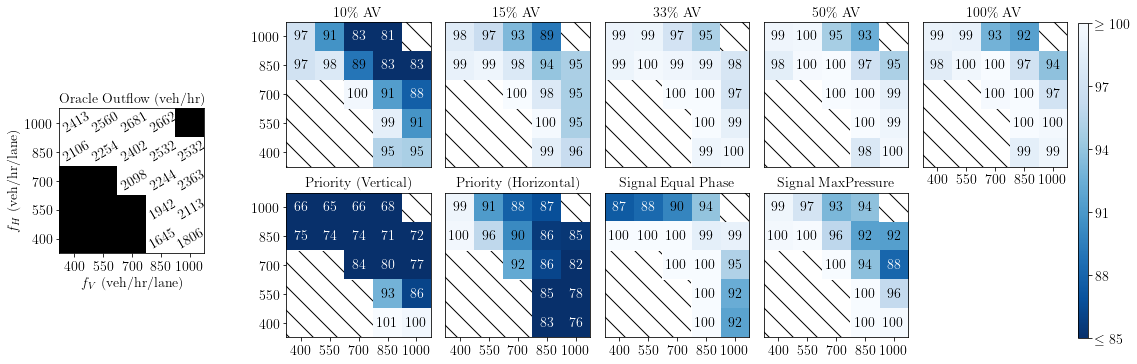

In [3]:
baseline_paths = [{flow: Baselines / f'eval_results/skip500_{key}_{flow}.csv' for flow in flows}
    for key in ['vpriority', 'hpriority', 'signal25_yellow0', 'mpbest_yellow0', 'signalbest_yellow0']
]
eval_paths = [{flow: D / f'eval_results/e{ckpt}_skip500_{flow}.csv' for flow in flows} for D, ckpt in Trained.values()]
eval_labels = [
    '10\% AV',
    '15\% AV',
    '33\% AV',
    '50\% AV',
    '100\% AV',
]
plot_heatmap(eval_paths, baseline_paths, eval_labels, asymmetric_labels,
    plot_mask=np.arange(10) != 9
)

## Time-Space Diagram

In [4]:
path = Results / 'twoway_2x1_penetration0.333/vehicle_info/e165_skip500_flow1000x700.csv'
vehicle_info = path.load()
xml = E.from_path(path.replace('.csv', '.net.xml'))
xml = E('net', *[x for x in xml if x._name == 'edge'])

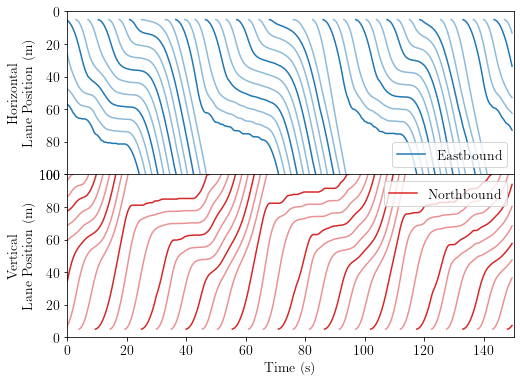

In [5]:
plot_time_space(vehicle_info, xml, colors=['C3', 'C0'], figsize=(8, 6), max_step=300)

# Two-way 3x3

In [6]:
Baselines = Results / 'twoway_3x3_baselines'
Trained = {av: (Results / f'twoway_2x1_penetration{av}', ckpt)
    for av, ckpt in zip([0.333, 0.5], [165, 150])
}

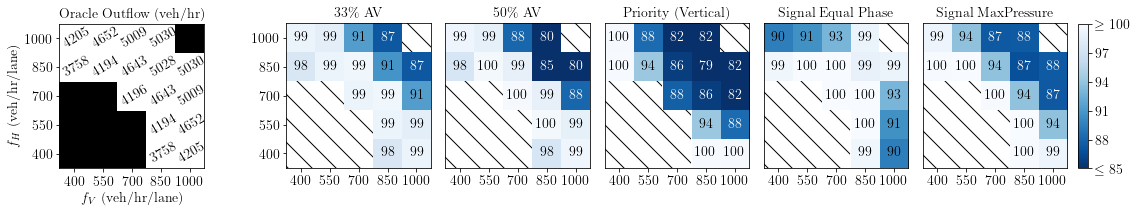

In [7]:
baseline_paths = [{flow: Baselines / f'eval_results/skip500_{key}_{flows_map[flow]}.csv' for flow in flows}
    for key in ['vpriority', 'signal25_yellow0', 'mpbest_yellow0', 'signalbest_yellow0']
]
eval_paths = [{flow: D / f'eval_results/e{ckpt}_3x3_skip500_{flows_map[flow]}.csv' for flow in flows} for D, ckpt in Trained.values()]
eval_labels = [
    '33\% AV',
    '50\% AV',
]
plot_heatmap(eval_paths, baseline_paths, eval_labels, symmetric_labels)

# Four-way 1x1

In [8]:
Baselines = Results / 'fourway_1x1_baselines'
Trained = {av: (Results / f'fourway_1x1_penetration{av}', ckpt)
    for av, ckpt in zip([0.333, 0.5], [190, 170])
}

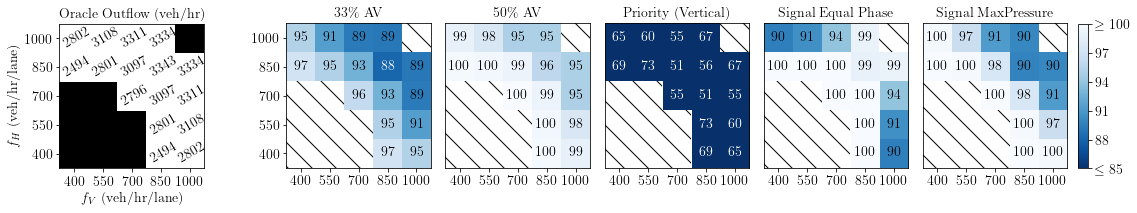

In [9]:
baseline_paths = [{flow: Baselines / f'eval_results/skip500_{key}_{flows_map[flow]}.csv' for flow in flows}
    for key in ['vpriority', 'signal25_yellow0', 'mpbest_yellow0', 'signalbest_yellow0']
]
eval_paths = [{flow: D / f'eval_results/e{ckpt}_skip500_{flows_map[flow]}.csv' for flow in flows} for D, ckpt in Trained.values()]
eval_labels = [
    '33\% AV',
    '50\% AV',
]
plot_heatmap(eval_paths, baseline_paths, eval_labels, symmetric_labels)